In [1]:
from pysqlite2 import dbapi2 as sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT 
A.CL8AA1990 AS pop90,
A.CL8AA2000 AS pop00,
A.CL8AA2010 AS pop10,
B.*
FROM nhgis_pop_race_norm_90_10 AS A
JOIN county_specialization AS B
    ON A.GISJOIN = B.GISJOIN
;
'''

df = pd.read_sql(qry, con, index_col='GISJOIN')
con.close()
len(df)

3143

In [3]:
df.columns

Index([u'pop90', u'pop00', u'pop10', u'Sus_10', u'Sstate_10', u'Sus_00',
       u'Sstate_00', u'Sus_90', u'Sstate_90'],
      dtype='object')

In [4]:
# create categories for pop change 2000 to 2010
# calc pop change in each decade
df['ppctchg_0010'] = ( df['pop10'] - df['pop00'] ) * 1.0 / df['pop00'] * 100
df['ppctchg_9000'] = ( df['pop00'] - df['pop90'] ) * 1.0 / df['pop90'] * 100
# growth categories 2000-2010
df['growth_cat'] = 0
df.loc[df['ppctchg_0010'] >= 5, 'growth_cat'] = 'growing'
df.loc[(df['ppctchg_0010'] < 5) & (df['ppctchg_0010'] >= 0 ), 'growth_cat'] = 'stable'
df.loc[df['ppctchg_0010'] < 0, 'growth_cat'] = 'shrinking'
# growth categories 1990-2000
df['growth_cat_90s'] = 0
df.loc[df['ppctchg_9000'] >= 5, 'growth_cat_90s'] = 'growing'
df.loc[(df['ppctchg_9000'] < 5) & (df['ppctchg_9000'] >= 0 ), 'growth_cat_90s'] = 'stable'
df.loc[df['ppctchg_9000'] < 0, 'growth_cat_90s'] = 'shrinking'
# xtab counties between 1990s and 2000s in terms of pop change category
pd.crosstab(df['growth_cat_90s'], df['growth_cat'], margins=True)

growth_cat,growing,shrinking,stable,All
growth_cat_90s,,,,
growing,1196,293,458,1947
shrinking,47,536,100,683
stable,57,272,184,513
All,1300,1101,742,3143


In [5]:
periods = [ ['90', '00'], ['00', '10'] ]
benchmarks = ['us', 'state']

for p in periods:
    start = p[0]
    end = p[1]
    for b in benchmarks:
        df['S_{}_diff_{}{}'.format(b,start,end)] = df['S{}_{}'.format(b, end)] - df['S{}_{}'.format(b, start)]

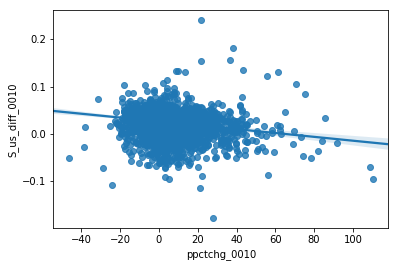

In [6]:
sns.regplot('ppctchg_0010', 'S_us_diff_0010', df)

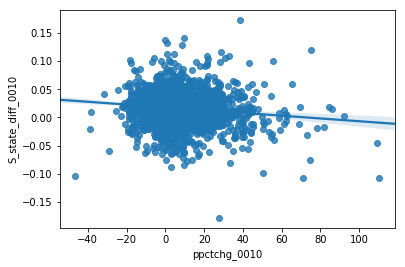

In [7]:
sns.regplot('ppctchg_0010', 'S_state_diff_0010', df)

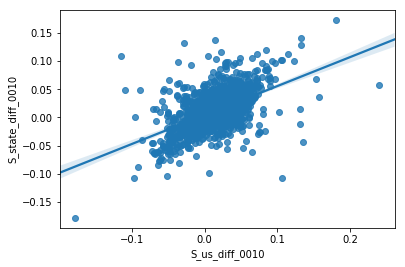

In [8]:
sns.regplot('S_us_diff_0010', 'S_state_diff_0010', df)

Text(0.5,1,u'2000-2010')

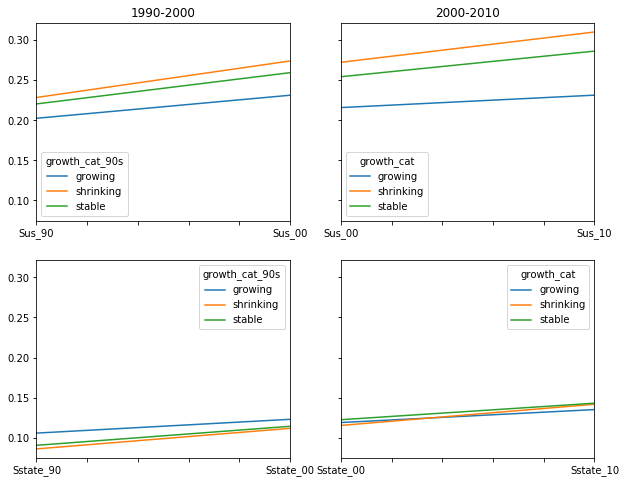

In [9]:
# plot change in median diversity across periods
# first row shows change in 4 group diversity
# second row shows change in 3 group diversity

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,8))
cols1 = ['Sus_90', 'Sus_00']
cols2 = ['Sus_00', 'Sus_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax1)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

cols1 = ['Sstate_90', 'Sstate_00']
cols2 = ['Sstate_00', 'Sstate_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax3)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax4)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

In [10]:
df.describe()

,pop90,pop00,pop10,Sus_10,Sstate_10,Sus_00,Sstate_00,Sus_90,Sstate_90,ppctchg_0010,ppctchg_9000,S_us_diff_9000,S_state_diff_9000,S_us_diff_0010,S_state_diff_0010
count,3.143000e+03,3.143000e+03,3.143000e+03,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,7.913136e+04,8.953926e+04,9.823275e+04,0.270354,0.163715,0.246321,0.147055,0.215052,0.127296,5.249544,11.105484,0.031269,0.019759,0.024033,0.016660
std,2.637270e+05,2.923624e+05,3.129012e+05,0.106132,0.109301,0.103861,0.107652,0.104917,0.104754,13.192471,16.047739,0.029629,0.028855,0.027170,0.025165
min,1.070000e+02,6.700000e+01,8.200000e+01,0.024890,0.000000,0.028688,0.000000,0.027275,0.000000,-46.604856,-42.340156,-0.126891,-0.133100,-0.177937,-0.179045
25%,1.032537e+04,1.116050e+04,1.110450e+04,0.201351,0.090014,0.181844,0.074692,0.158403,0.055563,-2.558316,1.021460,0.016398,0.006015,0.009692,0.004700
50%,2.208531e+04,2.460083e+04,2.585700e+04,0.276147,0.139230,0.250074,0.118894,0.213193,0.098165,3.179515,8.386227,0.039770,0.019145,0.029510,0.017300
75%,5.473338e+04,6.175151e+04,6.669900e+04,0.320564,0.204514,0.281809,0.187301,0.232783,0.165155,10.223635,17.454146,0.051197,0.034287,0.042182,0.030595
max,8.862994e+06,9.519099e+06,9.818605e+06,0.941409,0.844477,0.922698,0.847081,0.923922,0.871531,110.351356,191.050373,0.279126,0.245425,0.239847,0.172814


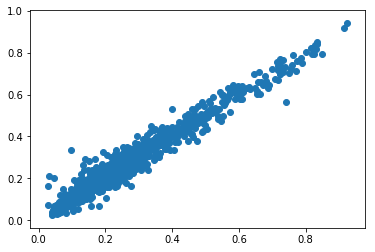

In [11]:
plt.scatter(df['Sus_00'], df['Sus_10'])

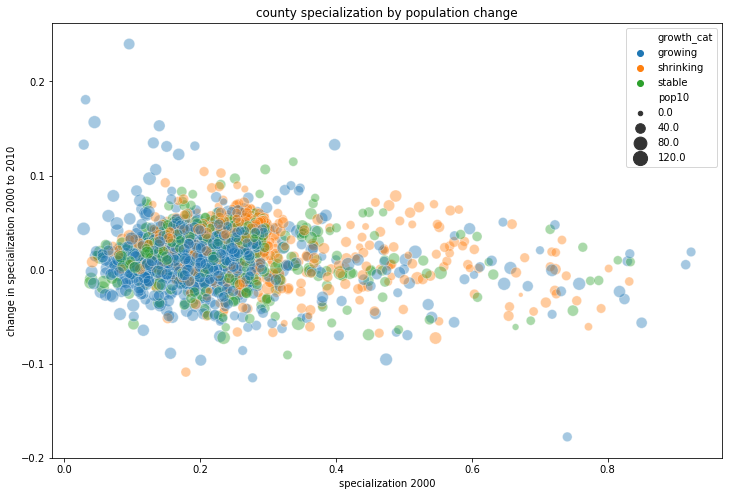

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
size = 100*( (np.log(df['pop10']) - np.log(df['pop10']).min() ) / (np.log(df['pop10']).max() - np.log(df['pop10']).min()) )
g=sns.scatterplot(df['Sus_00'], df['Sus_10'] - df['Sus_00'], 
                hue=df['growth_cat'], size=size, sizes=(20,200), alpha=0.4, ax=ax)
plt.xlabel('specialization 2000')
plt.ylabel('change in specialization 2000 to 2010')
plt.title("county specialization by population change")
plt.savefig("/home/eric/Documents/franklin/narsc2018/figures/specialization.png", dpi=300)

In [13]:
samp = df.sample(n=250)

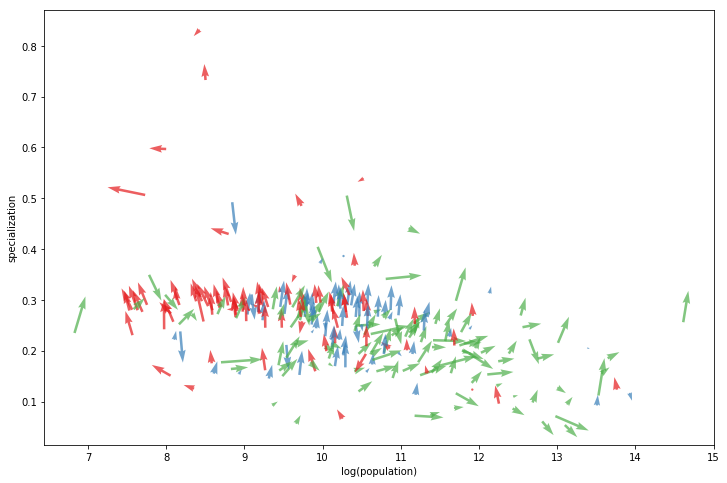

In [14]:
fig, ax = plt.subplots(figsize=(12,8))

X = np.log(samp['pop00'])
Y = samp['Sus_00']
# U = samp['ppctchg_0010']
U = np.log(samp['pop10']) - np.log(samp['pop00'])
V = samp['S_us_diff_0010']

samp.loc[samp['growth_cat']=='shrinking', 'color'] = '#e41a1c'
samp.loc[samp['growth_cat']=='growing', 'color'] = '#4daf4a'
samp.loc[samp['growth_cat']=='stable', 'color'] = '#377eb8'

plt.quiver(X, Y, U, V, scale_units='xy', angles='xy', scale=1, color=samp['color'], alpha=0.7)
# plt.quiver(X, Y, U, V, scale_units='xy', angles='xy')


# ax.set_ylim([0,.8])
# ax.set_xlim([0,15])

plt.xlabel('log(population)')
plt.ylabel('specialization')
# plt.title("Vectors ")
plt.savefig("/home/eric/Documents/franklin/narsc2018/figures/specialization_quiver.png", dpi=300)

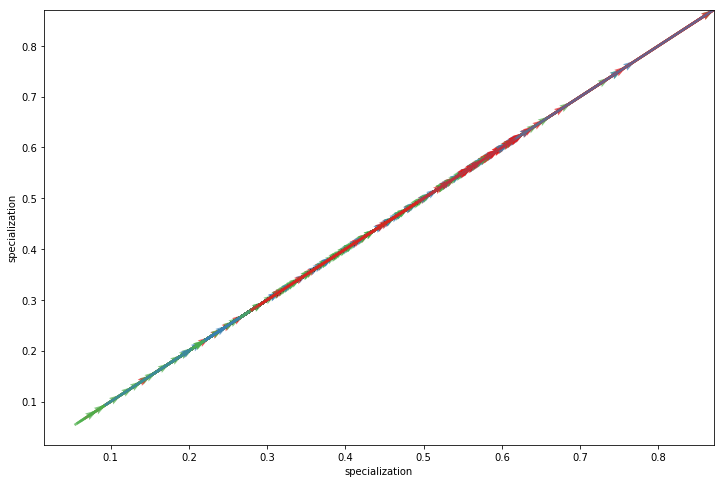

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

X = samp['Sus_00']
Y = samp['Sus_00']
U = samp['Sus_10']
V = samp['Sus_10']

samp.loc[samp['growth_cat']=='shrinking', 'color'] = '#e41a1c'
samp.loc[samp['growth_cat']=='growing', 'color'] = '#4daf4a'
samp.loc[samp['growth_cat']=='stable', 'color'] = '#377eb8'

plt.quiver(X, Y, U, V, scale_units='xy', angles='xy', scale=1, color=samp['color'], alpha=0.7)

# ax.set_ylim([0,.8])
# ax.set_xlim([0,15])

plt.xlabel('specialization')
plt.ylabel('specialization')
# plt.title("Vectors ")
plt.savefig("/home/eric/Documents/franklin/narsc2018/figures/specialization_quiver_spec_only.png", dpi=300)

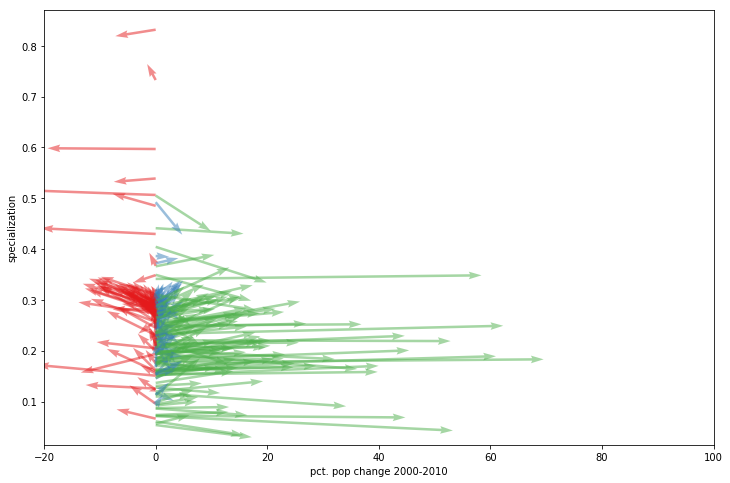

In [16]:
fig, ax = plt.subplots(figsize=(12,8))

samp['zeros'] = 0
X = samp['zeros']
Y = samp['Sus_00']
U = samp['ppctchg_0010']
V = samp['S_us_diff_0010']

samp.loc[samp['growth_cat']=='shrinking', 'color'] = '#e41a1c'
samp.loc[samp['growth_cat']=='growing', 'color'] = '#4daf4a'
samp.loc[samp['growth_cat']=='stable', 'color'] = '#377eb8'

plt.quiver(X, Y, U, V, scale_units='xy', angles='xy', scale=1, color=samp['color'], alpha=0.5)
# plt.quiver(X, Y, U, V, scale_units='xy', angles='xy')


# ax.set_ylim([0,.8])
ax.set_xlim([-20,100])

plt.xlabel('pct. pop change 2000-2010')
plt.ylabel('specialization')
# plt.title("Vectors ")
plt.savefig("/home/eric/Documents/franklin/narsc2018/figures/specialization_quiver_pctchg.png", dpi=300)

In [17]:
U.describe()

count    250.000000
mean       6.530311
std       14.394638
min      -38.170624
25%       -1.420681
50%        3.629630
75%       13.037262
max       69.528255
Name: ppctchg_0010, dtype: float64

# Regression analysis

In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [19]:
df.columns

Index([u'pop90', u'pop00', u'pop10', u'Sus_10', u'Sstate_10', u'Sus_00',
       u'Sstate_00', u'Sus_90', u'Sstate_90', u'ppctchg_0010', u'ppctchg_9000',
       u'growth_cat', u'growth_cat_90s', u'S_us_diff_9000',
       u'S_state_diff_9000', u'S_us_diff_0010', u'S_state_diff_0010'],
      dtype='object')

In [21]:
# regress change in specialization (t2 - t1)  on pop change
m = 'S_us_diff_0010 ~ ppctchg_0010'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     60.90
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           8.09e-15
Time:                        20:23:50   Log-Likelihood:                 6936.0
No. Observations:                3143   AIC:                        -1.387e+04
Df Residuals:                    3141   BIC:                        -1.386e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0262      0.001     51.847   

In [23]:
# regress change in specialization (t2 - t1)  on pop change
m = 'S_us_diff_9000 ~ ppctchg_9000'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_9000   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     102.8
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           8.70e-24
Time:                        20:25:03   Log-Likelihood:                 6674.0
No. Observations:                3143   AIC:                        -1.334e+04
Df Residuals:                    3141   BIC:                        -1.333e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0356      0.001     58.530   

### Interpretation
Base models show pop change is negatively associated with specialization, meaning as places grow they become more like the nation in terms of proportion of race/ethnic groups. A 10% increase in population is associated with a -0.004 decrease in specialization - a very small amount, as we would expect based on the slope of the linear plot above in the notebook. Further, the range of values of the dependent value is very small.

Text(0,0.5,u'specialization 2010')

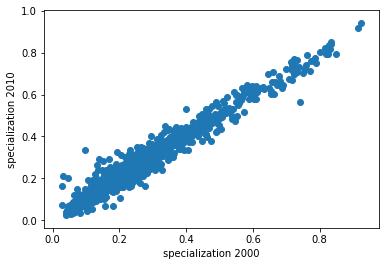

In [35]:
fix, ax = plt.subplots()
plt.scatter(df['Sus_00'], df['Sus_10'])
plt.xlabel('specialization 2000')
plt.ylabel('specialization 2010')

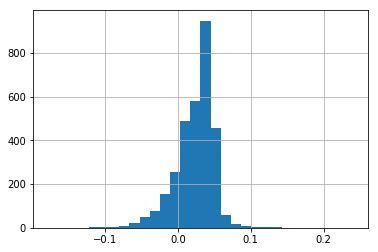

In [36]:
# plot histogram for difference in values 00-10
df['S_us_diff_0010'].hist(bins=30)

Text(0,0.5,u'specialization 2010')

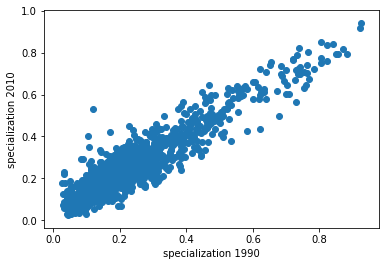

In [37]:
# what about 20 year diff?
fix, ax = plt.subplots()
plt.scatter(df['Sus_90'], df['Sus_10'])
plt.xlabel('specialization 1990')
plt.ylabel('specialization 2010')

In [22]:
# regress change in specialization (t2 - t1)  on pop change
# add specialization in base year
m = 'S_us_diff_0010 ~ ppctchg_0010 + Sus_00'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     37.93
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           5.29e-17
Time:                        20:24:21   Log-Likelihood:                 6952.0
No. Observations:                3143   AIC:                        -1.390e+04
Df Residuals:                    3140   BIC:                        -1.388e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0330      0.002     18.810   

In [24]:
# regress change in specialization (t2 - t1)  on pop change
# add specialization in base year
m = 'S_us_diff_0010 ~ ppctchg_0010 + Sus_00 + pop00'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

                            OLS Regression Results                            
Dep. Variable:         S_us_diff_0010   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     26.99
Date:                Tue, 09 Oct 2018   Prob (F-statistic):           3.13e-17
Time:                        20:30:05   Log-Likelihood:                 6966.2
No. Observations:                3143   AIC:                        -1.392e+04
Df Residuals:                    3139   BIC:                        -1.390e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0341      0.002     18.821   